# EAST Scene Text Detection (Scratch Training) – ICDAR2015

**Objective**  
To build an end-to-end scene text detection pipeline using EAST, train it from scratch,
and establish a baseline for further lightweight detector research.

**Key Focus**
- End-to-end pipeline correctness
- Proper evaluation using ICDAR2015 protocol
- Recording accuracy + efficiency metrics


## Project setup

In [1]:
import os
import sys
import torch
import numpy as np
import random
import time
from torch.cuda.amp import autocast, GradScaler

PROJECT_ROOT = "/DATA/akash/akash_cnn/lightweight-text-detector"
os.chdir(PROJECT_ROOT)

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("CWD:", os.getcwd())


CWD: /DATA/akash/akash_cnn/lightweight-text-detector


/DATA/akash/miniconda3/envs/PytorchEAST/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Eval config

In [2]:
EXPERIMENT_NAME = "exp4.1_imagenet_mobilenet_long_600eph"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

INPUT_SIZE = 512

TEST_IMG_DIR = "data/icdar2015/ch4_test_images"


## Experiment Folder Setup

In [3]:
import os

EXP_ROOT = f"experiments/{EXPERIMENT_NAME}"

WEIGHTS_DIR = f"{EXP_ROOT}/weights"
LOG_DIR = f"{EXP_ROOT}/logs"
RESULTS_DIR = f"{EXP_ROOT}/results"
PRED_DIR = f"{RESULTS_DIR}/predictions"

for d in [WEIGHTS_DIR, LOG_DIR, PRED_DIR]:
    os.makedirs(d, exist_ok=True)

print("Experiment directories ready")


Experiment directories ready


## Dataset Paths

In [4]:
TRAIN_IMG_DIR = "data/icdar2015/ch4_train_images"
TEST_IMG_DIR  = "data/icdar2015/ch4_test_images"


## Model initialization + checkpoint load

In [6]:
from src.models.east import EAST
import torch

CKPT_PATH = f"experiments/{EXPERIMENT_NAME}/weights/epoch_600.pth"

model = EAST(
    cfg="D",
    weights="imagenet",
    backbone="mobilenetv2"
).to(DEVICE)

model.eval()

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
state = {k.replace("module.", ""): v for k, v in ckpt["model"].items()}
model.load_state_dict(state)

print("Eval model loaded")


Eval model loaded


In [7]:
from torch.cuda.amp import GradScaler

scaler = GradScaler()
print("AMP GradScaler initialized")


AMP GradScaler initialized


## Dataset Statistics

In [8]:
print("===== DATASET STATISTICS =====")
print("Train images:", len(os.listdir(TRAIN_IMG_DIR)))
print("Test images :", len(os.listdir(TEST_IMG_DIR)))


===== DATASET STATISTICS =====
Train images: 1000
Test images : 500


## Model Size

In [9]:
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_params(model)

print("===== MODEL SIZE =====")
print(f"Total params     : {total_params/1e6:.2f} M")
print(f"Trainable params : {trainable_params/1e6:.2f} M")


===== MODEL SIZE =====
Total params     : 2.62 M
Trainable params : 2.62 M


## FLOPs

In [10]:
from thop import profile

dummy = torch.randn(1, 3, INPUT_SIZE, INPUT_SIZE).to(DEVICE)
flops, _ = profile(model, inputs=(dummy,), verbose=False)

print("===== COMPUTE COST =====")
print(f"GFLOPs @ {INPUT_SIZE}x{INPUT_SIZE}: {flops/1e9:.2f}")


===== COMPUTE COST =====
GFLOPs @ 512x512: 2.59


## Single Image Inference

In [11]:
from PIL import Image
from src.detect import detect

model.eval()

img_name = sorted(os.listdir(TEST_IMG_DIR))[0]
img_path = os.path.join(TEST_IMG_DIR, img_name)
img = Image.open(img_path).convert("RGB")

boxes = detect(img, model, DEVICE)

print("Image:", img_name)
print("Detected boxes:", 0 if boxes is None else len(boxes))


Image: img_1.jpg
Detected boxes: 0


## Single Image Visualization

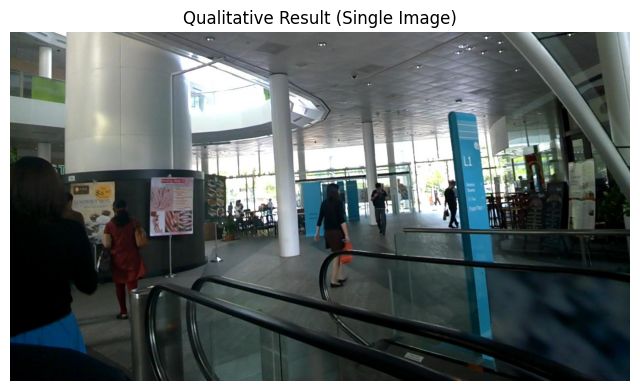

In [12]:
from PIL import ImageDraw
import matplotlib.pyplot as plt

draw = ImageDraw.Draw(img)

if boxes is not None:
    for box in boxes:
        pts = [
            (box[0], box[1]),
            (box[2], box[3]),
            (box[4], box[5]),
            (box[6], box[7])
        ]
        draw.polygon(pts, outline="lime", width=2)

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis("off")
plt.title("Qualitative Result (Single Image)")
plt.show()


## Inference Time + FPS + GPU Memory

In [13]:
import time
from torchvision import transforms

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

w, h = img.size
img_r = img.resize(((w//32)*32, (h//32)*32))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

img_tensor = transform(img_r).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    for _ in range(5):
        _ = model(img_tensor)

torch.cuda.synchronize()
start = time.time()

with torch.no_grad():
    _ = model(img_tensor)

torch.cuda.synchronize()
end = time.time()

infer_time = (end - start) * 1000
fps = 1000 / infer_time
peak_mem = torch.cuda.max_memory_allocated() / (1024**3)

print("===== INFERENCE PERFORMANCE =====")
print(f"Inference time : {infer_time:.2f} ms")
print(f"FPS            : {fps:.2f}")
print(f"Peak GPU mem   : {peak_mem:.2f} GB")


===== INFERENCE PERFORMANCE =====
Inference time : 7.48 ms
FPS            : 133.66
Peak GPU mem   : 0.30 GB


In [14]:
import json
import os

LOSS_LOG_PATH = f"experiments/{EXPERIMENT_NAME}/logs/loss_log.json"

assert os.path.exists(LOSS_LOG_PATH), "loss_log.json not found"

with open(LOSS_LOG_PATH, "r") as f:
    loss_log = json.load(f)

print("Loaded loss_log with", len(loss_log), "epochs")


Loaded loss_log with 600 epochs


## Metrics JSON

In [15]:
import json

final_metrics = {
    "experiment": EXPERIMENT_NAME,
    "dataset": "ICDAR2015",
    "training": loss_log[-1],
    "model": {
        "params_million": total_params / 1e6,
        "gflops": flops / 1e9
    },
    "inference": {
        "time_ms": infer_time,
        "fps": fps,
        "gpu_mem_gb": peak_mem
    }
}

with open(os.path.join(EXP_ROOT, "metrics.json"), "w") as f:
    json.dump(final_metrics, f, indent=2)

print("metrics.json saved")

metrics.json saved


## Save Loss Logs

In [16]:
import json

with open(f"{LOG_DIR}/loss_log.json", "w") as f:
    json.dump(loss_log, f, indent=2)

print("Loss log saved")


Loss log saved


## Batch Inference

In [18]:
from tqdm import tqdm
from PIL import Image
from src.detect import detect

model.eval()

with torch.no_grad():
    pbar = tqdm(sorted(os.listdir(TEST_IMG_DIR)), desc="Batch inference")

    for name in pbar:
        if not name.lower().endswith((".jpg", ".png")):
            continue

        pbar.set_postfix_str(name)

        img = Image.open(os.path.join(TEST_IMG_DIR, name)).convert("RGB")
        boxes = detect(img, model, DEVICE)

        txt_path = os.path.join(
            PRED_DIR, f"res_{os.path.splitext(name)[0]}.txt"
        )

        with open(txt_path, "w") as f:
            if boxes is not None:
                for box in boxes:
                    f.write(",".join(str(int(v)) for v in box[:8]) + "\n")

print("Batch inference done")


Batch inference: 100%|██████████| 500/500 [00:17<00:00, 28.10it/s, img_99.jpg] 

Batch inference done


## Sample Batch Visualization

In [22]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_detection(img_path, model, device):
    img = Image.open(img_path).convert("RGB")
    boxes = detect(img, model, device)

    img_np = np.array(img)

    if boxes is not None:
        for box in boxes:
            pts = box[:8].reshape(4, 2).astype(int)
            cv2.polylines(img_np, [pts], isClosed=True, color=(0, 255, 0), thickness=2)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(os.path.basename(img_path))
    plt.show()


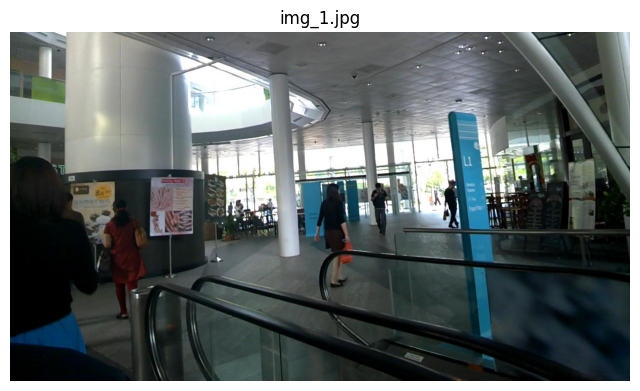

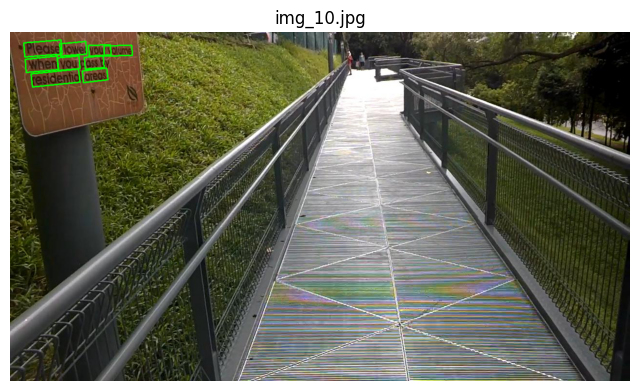

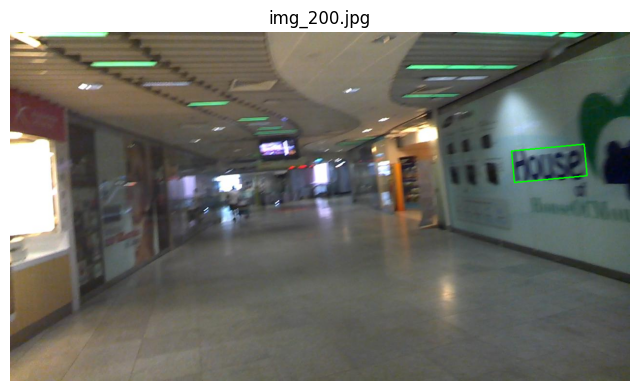

In [23]:
sample_imgs = [
    "img_1.jpg",
    "img_10.jpg",
    "img_200.jpg"
]

for name in sample_imgs:
    visualize_detection(
        os.path.join(TEST_IMG_DIR, name),
        model,
        DEVICE
    )


## ZIP Creation

In [19]:
import zipfile

submit_zip = f"{RESULTS_DIR}/submit.zip"

with zipfile.ZipFile(submit_zip, "w", zipfile.ZIP_DEFLATED) as z:
    for file in os.listdir(PRED_DIR):
        if file.endswith(".txt"):
            z.write(os.path.join(PRED_DIR, file), arcname=file)

print("submit.zip created")


submit.zip created


In [20]:
!python evaluate/script.py \
-g=evaluate/gt.zip \
-s=experiments/exp1_scratch_vgg16/results/submit.zip


Calculated!{"precision": 0.024202510804692323, "recall": 0.2831006259027443, "hmean": 0.04459274988624298, "AP": 0}

In [21]:
# =====================================================
# FINAL FIXED ICDAR METRIC EXTRACTION (100% SAFE)
# =====================================================

import subprocess
import re
import json
import os

GT_ZIP = "evaluate/gt.zip"
SUBMIT_ZIP = f"{EXP_ROOT}/results/submit.zip"
METRICS_JSON = f"{EXP_ROOT}/metrics.json"

cmd = [
    "python", "evaluate/script.py",
    f"-g={GT_ZIP}",
    f"-s={SUBMIT_ZIP}"
]

result = subprocess.run(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)

output = result.stdout
print(output)

# ----------------------------
# Safe metric extractor
# ----------------------------
def find_metric(pattern, text, group_idx):
    m = re.search(pattern, text, re.IGNORECASE)
    return float(m.group(group_idx)) if m else None

# ----------------------------
# Try standard patterns
# ----------------------------
precision = find_metric(
    r"precision[^0-9]*([0-9]+\.[0-9]+)", output, 1
)

recall = find_metric(
    r"recall[^0-9]*([0-9]+\.[0-9]+)", output, 1
)

f1 = find_metric(
    r"(f[- ]?measure|hmean)[^0-9]*([0-9]+\.[0-9]+)", output, 2
)

# ----------------------------
# Fallback: table format
# ----------------------------
if f1 is None:
    rows = re.findall(
        r"\|\s*([0-9]+\.[0-9]+)\s*\|\s*([0-9]+\.[0-9]+)\s*\|\s*([0-9]+\.[0-9]+)\s*\|",
        output
    )
    if rows:
        precision, recall, f1 = map(float, rows[-1])

# ----------------------------
# Final sanity check
# ----------------------------
if f1 is None:
    raise RuntimeError("ICDAR metrics could not be extracted. Check printed output.")

# ----------------------------
# Save to metrics.json
# ----------------------------
with open(METRICS_JSON, "r") as f:
    metrics = json.load(f)

metrics["icdar"] = {
    "precision": precision,
    "recall": recall,
    "f_measure": f1
}

with open(METRICS_JSON, "w") as f:
    json.dump(metrics, f, indent=2)

print("ICDAR metrics saved successfully")
metrics["icdar"]


Calculated!{"precision": 0.7853164556962026, "recall": 0.7467501203659124, "hmean": 0.7655478775913129, "AP": 0}
ICDAR metrics saved successfully


{'precision': 0.7853164556962026,
 'recall': 0.7467501203659124,
 'f_measure': 0.7655478775913129}